In this notebook, we'll learn how to use GANs to do semi-supervised learning.

In supervised learning, we have a training set of inputs $x$ and class labels $y$. We train a model that takes $x$ as input and gives $y$ as output.

In semi-supervised learning, our goal is still to train a model that takes $x$ as input and generates $y$ as output. However, not all of our training examples have a label $y$. We need to develop an algorithm that is able to get better at classification by studying both labeled $(x, y)$ pairs and unlabeled $x$ examples.

To do this for the SVHN dataset, we'll turn the GAN discriminator into an 11 class discriminator. It will recognize the 10 different classes of real SVHN digits, as well as an 11th class of fake images that come from the generator. The discriminator will get to train on real labeled images, real unlabeled images, and fake images. By drawing on three sources of data instead of just one, it will generalize to the test set much better than a traditional classifier trained on only one source of data.

In [227]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [228]:
!mkdir data

하위 디렉터리 또는 파일 data이(가) 이미 있습니다.


In [229]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [230]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

In [231]:
trainset['X'].shape

(32, 32, 3, 73257)

In [232]:
train_x = np.rollaxis(trainset['X'], 3)

In [233]:
train_x.shape

(73257, 32, 32, 3)

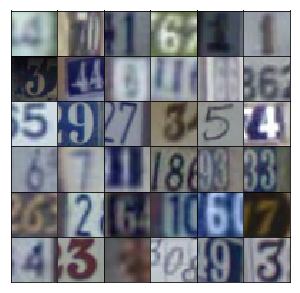

In [234]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

총 73257개의 데이터가 있다.

In [235]:
trainset.items()

dict_items([('__globals__', []), ('y', array([[1],
       [9],
       [2],
       ..., 
       [1],
       [6],
       [9]], dtype=uint8)), ('__version__', '1.0'), ('__header__', b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011'), ('X', array([[[[ 33,  84,  19, ...,  92, 190, 216],
         [ 30,  76,  54, ...,  78, 188, 217],
         [ 38,  59, 110, ..., 101, 191, 212]],

        [[ 15,  86,  20, ...,  94, 205, 221],
         [ 23,  73,  52, ...,  82, 203, 222],
         [ 19,  66, 111, ..., 105, 206, 217]],

        [[ 15,  77,  25, ..., 114, 220, 226],
         [ 17,  78,  57, ..., 101, 218, 227],
         [ 19,  56, 116, ..., 125, 220, 221]],

        ..., 
        [[ 72,  90,  65, ..., 200, 229, 200],
         [ 65,  78, 144, ..., 201, 231, 199],
         [ 56,  69, 223, ..., 203, 224, 191]],

        [[ 82,  88,  78, ..., 192, 229, 193],
         [ 77,  77, 148, ..., 193, 229, 188],
         [ 57,  67, 218, ..., 195, 224, 182]],

        [[ 89,  88,

[-1,+1] 범위로 scale함

In [236]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [237]:
# my_range = (-1, 1)
# min, max = my_range
# print(min, max)

training, validation, test로 나누긴하지만 validation을 이번 예제에선 사용하지 않음.

실제 개발에선 validation을 통해서 hyper parameter를 조율해야 한다. 

label mask를 이용해서 어떤 label은 있는 척하고 어떤 label을 없는 척할지 정한다.
1000개만 label을 있다고 본다.
batches 메소드에서 train을 명시하면 이 label amst를 얻을 수 있다. 
test 모드에선 얻지 못한다.

In [238]:
# a = np.ones((3,4,5,6))
# print(np.rollaxis(a,3).shape)
# print(np.rollaxis(a,3))

In [239]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:5000] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        # dataset이라는 이름을 가진 객체를 찾고 이에 해당되는 y_name attribute를 찾는다.
        # dataset.train_y attribute가 나오고 이것의 length
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [240]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

In [241]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 8,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        # Reshape it to start the convolutional stack
        
        
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 8))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4 x 4 x 1024
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 4, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8 x 8 x 512
        
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult*2, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha*x3, x3)
        # 16 x 16 x 256
        
        x4 = tf.layers.conv2d_transpose(x3, size_mult, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha*x4, x4)
        # 16 x 16 x 128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, output_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        # 32 x 32 x3
        
        # [-1, 1] 으로 하기 위해서 tanh
        out = tf.tanh(logits)
        
        return out

discriminator는 classifire로 동작한다.  
- MaxPooling이나 avg Pooling은 사용하지 않는다. 대신 stride 2짜리 conv layer를 사용한다.

- DCGAN paper 에 따라서, 첫번째 레이어는 Batch Normalization을 넣지 않는다. 만약 넣는다면 generator에서 나오는 결과가 정확한 mean 과 standard deviation을 가지지 못한다. 

- Dropout을 중간중간에 넣는다. Regularization : test error가 training error보다 높지 않게끔 한다. 1000개의 labeled만 쓰기 떄문에 overfitting을 일어나지 않게끔 해야한다.
- Leaky ReLU : 항상 아래로 보낼 gradient가 있다. propagation을 잘 일어나도록

In [242]:
# There are two ways of solving this problem.
# One is to have the matmul at the last layer output all 11 classes.
# The other is to output just 10 classes, and use a constant value of 0 for
# the logit for the last class. This still works because the softmax only needs
# n independent logits to specify a probability distribution over n + 1 categories.
# We implemented both solutions here.
extra_class = 0
def discriminator(x, reuse=False, training=True, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate/2.5)
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        # 16 x 16 x 64
        
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn2 = tf.layers.batch_normalization(x2, training=training)
        relu2 = tf.maximum(alpha * bn2, bn2) ###################### typo
        relu2 = tf.layers.dropout(relu2, rate=drop_rate)
        # 8 x 8 x 64
        
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn3 = tf.layers.batch_normalization(x3, training=training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        # 4 x 4 x 64
        
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn4 = tf.layers.batch_normalization(x4, training=training)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4 x 4 x 128
        
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn5 = tf.layers.batch_normalization(x5, training=training)
        relu5 = tf.maximum(alpha * bn5, bn5)
        # 4 x 4 x 128
        
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        bn6 = tf.layers.batch_normalization(x6, training=training)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        # 2 x 2 x 128
        
        #x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid') #####typo
        x7 = tf.layers.conv2d(relu6, 2 * size_mult, 2, strides=1, padding='valid',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        # 1 x 1 x 128
        
        # Don't use bn on this layer, because bn would set the mean of each feature
        # to the bn mu parameter.
        # This layer is used for the feature matching loss, which only works if
        # the means can be different when the discriminator is run on the data than
        # when the discriminator is run on the generator samples.
        relu7 = tf.maximum(alpha * x7, x7)
        
        # Flatten it by global average pooling
        # features = tf.layers.average_pooling2d(inputs=relu7, strides = 1, padding='valid')
        # axis 0 = batch, axis1= height, axis2 = width, axis3 = channels
        features = tf.reduce_mean(relu7, (1, 2))
        # batch x 4 x 1 x 1
        
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, num_classes + extra_class)
        # 1 x 10 or 1 x 11
        # 총 11개의 서로 다른 클래스에 대한 확률이 필요하다. 이걸 softmax로 할 수 있는데
        # over-parameterized하다. 
        # 만약 클래스 10개에 대한 확률을 알고 있다면 11번째 클래스 확률을 1 - sum(클래스 10개)
        
        # 따라서 2가지 선택권이 있다.
        # 11개 클래스로 matmul을 할건지(서로 independently parmeterized)
        # 아니면 extra_class를 0으로 하고 10개의 클래스에 대한 확률만 얻을지
        
        # Set gan_logits such that P(input is real | input) = sigmoid(gan_logits).
        # Keep in mind that class_logits gives you the probability distribution over all the real
        # classes and the fake class. You need to work out how to transform this multiclass softmax
        # distribution into a binary real-vs-fake decision that can be described with a sigmoid.
        # Numerical stability is very important.
        # You'll probably need to use this numerical stability trick:
        # log sum_i exp a_i = max + log sum_i exp(a_i - max).
        # This is numerically stable when m = max_i a_i.
        # (It helps to think about what goes wrong when...
        #   1. One value of a_i is very large
        #   2. All the values of a_i are very negative
        # This trick and this value of m fix both those cases, but the naive implementation and
        # other values of m encounter various problems)
        
        # 10개의 클래스 소프트맥스를 할지 11개의 클래스 소프트맥스를 할지에 따라 다르다.
        if extra_class:
            # 만약 11개 클래스 전략을 한다면 11개 클래스 로짓을 [10, 1] 개로 나눈다.
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
            
        else:
            # 만약 10개 클래스 전략을 한다면 
            # 나머진 소프트 맥스쪽에서 fake class에 대해서 확률을 줄 것이다.
            real_class_logits = class_logits
            fake_class_logits = 0.
            
        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx
        
        # [Log(sum(e_i)) + Max]<- 여기까진 log sum exp인데 
        # 뒤에 fake_class_logit을 뺀 이유 
        # fake 이미지에 대한 classfication logit은 고려하지 않겠다는 뜻
        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features

In [243]:
def model_loss(input_real, input_z, training, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param output_dim: The number of channels in the output image
    :param y: Integer class labels
    :param num_classes: The number of classes
    :param alpha: The slope of the left half of leaky ReLU activation
    :param drop_rate: The probability of dropping a hidden unit
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    # These numbers multiply the size of each layer of the generator and the discriminator,
    # respectively. You can reduce them to run your code faster for debugging purposes.
    g_size_mult = 32
    d_size_mult = 64
    
    # Here we run the generator and the discriminator
    g_model = generator(input_z, output_dim, alpha=alpha, size_mult=g_size_mult)
    d_on_data = discriminator(input_real, training=training,alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
    d_on_samples = discriminator(g_model, training=training,reuse=True, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    # Here we compute `d_loss`, the loss for the discriminator.
    # This should combine two different losses:
    #  1. The loss for the GAN problem, where we minimize the cross-entropy for the binary
    #     real-vs-fake classification problem.
    #  2. The loss for the SVHN digit classification problem, where we minimize the cross-entropy
    #     for the multi-class softmax. For this one we use the labels. Don't forget to ignore
    #     use `label_mask` to ignore the examples that we are pretending are unlabeled for the
    #     semi-supervised learning problem.
    
    # Unsupervised Parts
    # 하나는 진짜 데이터 , 하나는 generator에서 나온 데이터
    # 따라서 binary classfication(real image, generated image) problem을 해결하는 것 
    # -> 그러므로 sigmoid_cross_entropy_with_logit을 사용
    # log-sum-exp을 이용해서 만든 gan_logit을 사용하자
    
    # Batch 단위로 온 logits들에 대한 entropy를 구하고 전체를 평균내버리자. 
    # reduce_mean에 특정 축을 명시하지 않으면 그냥 모두 밀어버린다.
    smooth=0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = gan_logits_on_data,\
                                                          labels=tf.ones_like(gan_logits_on_data)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= gan_logits_on_samples,\
                                                          labels=tf.zeros_like(gan_logits_on_samples)))
    
    # Supervised Portion
    
    # y는 placeholder인데 shape = [None]
    # squeeze하면 1짜리 axis를 없앤다. -> 그냥 batch 사이즈만 남음
    y = tf.squeeze(y)
    # num_classes로 나중에 10을 입력받음.
    # 미니배치 마다 loss가 얼마인지를 softmax_cross_entropy로 계산한다. 
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = class_logits_on_data,\
                                                                 labels = tf.one_hot(y, num_classes + extra_class,\
                                                                                    dtype = tf.float32))
    
    # 그런데 label mask가 사용하라고 한 데이터에 대해서만 class_entropy를 알아야함.
    # 현재 shape가 batch_size x class size
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    label_mask = tf.squeeze(tf.to_float(label_mask))
    # mean cross entropy를 구한다. 
    # tf.reduce_mean을 생각할 수 있겠지만 
    # 128 사이즈 미니 배치속에서 label mask에 해당되지 않는 녀석이 많이 존재할 수도 있다.
    # 따라서 explicitly하게 mean의 numerator을 구한다.
    # denominator는 1이거나 이번 배치에 있는 label의 갯수(1을 넣는 이유는 혹시 라벨 묻은게 0일 수 있어서)
    d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1.,tf.reduce_sum(label_mask))
    
    # Total D_loss
    d_loss = d_loss_real + d_loss_fake + d_loss_class
    
    # Here we set `g_loss` to the "feature matching" loss invented by Tim Salimans at OpenAI.
    # This loss consists of minimizing the absolute difference between the expected features
    # on the data and the expected features on the generated samples.
    # This loss works better for semi-supervised learning than the tradition GAN losses.
    
    # 특정한 dataset의 통계량과 다른 dataset의 통계량이 비슷하게 만드는 것을 
    # Moment matching이라는 불리는 learning technique이다.
    # my first answer : g_loss = abs(data_features - sample_features)

    # feature의 shape는 batch x 4 x 1 x 1
    # axis=0을 밀면서 mean을 구한다 = batch의 평균을 구하겠다.
    # we compute the moments on the data set itself by taking the mean across the mini-batch 
    # of the features that we pulled out of the discriminator.
    data_moments = tf.reduce_mean(data_features, axis=0)
    sample_moments = tf.reduce_mean(sample_features, axis=0)
    
    g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))
    
    pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
    eq = tf.equal(tf.squeeze(y), pred_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return d_loss, g_loss, correct, masked_correct, g_model

In [244]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases to update. Get them separately for the discriminator and the generator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Check 기능
    # 가끔식 scope밖에 code를 쓰는 실수를 범할 수 있어서
    # 이번에 scope를 두개를 사용했기 때문에 반드시 t_vars는 d_vars나 g_vars안에 포함되어야 함.
    for t in t_vars:
        assert t in d_vars or t in g_vars
    
    # Minimize both players' costs simultaneously
    g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, \
                                         beta1 = beta1).minimize(g_loss, var_list = g_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, \
                                         beta1 = beta1).minimize(d_loss, var_list = d_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    
    return d_train_opt, g_train_opt, shrink_lr

In [245]:
class GAN:
    """
    A GAN model.
    :param real_size: The shape of the real data.
    :param z_size: The number of entries in the z code vector.
    :param learnin_rate: The learning rate to use for Adam.
    :param num_classes: The number of classes to recognize.
    :param alpha: The slope of the left half of the leaky ReLU activation
    :param beta1: The beta1 parameter for Adam.
    """
    def __init__(self, real_size, z_size, learning_rate, num_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        inputs = model_inputs(real_size, z_size)
        self.input_real, self.input_z, self.y, self.label_mask = inputs
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        self.training = tf.placeholder(tf.bool)
        loss_results = model_loss(self.input_real, self.input_z,self.training,
                                  real_size[2], self.y, num_classes,
                                  label_mask=self.label_mask,
                                  alpha=0.2,
                                  drop_rate=self.drop_rate)
        self.d_loss, self.g_loss, self.correct, self.masked_correct, self.samples = loss_results
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [246]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [247]:
def train(net, dataset, epochs, batch_size, figsize=(5,5)):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            print("Epoch",e)
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_opt, net.g_opt, net.masked_correct],
                                         feed_dict={net.input_real: x, net.input_z: batch_z,
                                                    net.y : y, net.label_mask : label_mask,
                                                    net.training : True})
                t2 = time.time()
                num_correct += correct

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print("\t\tClassifier train accuracy: ", train_accuracy)
            
            num_examples = 0
            num_correct = 0
            for x, y in dataset.batches(batch_size, which_set="test"):
                assert 'int' in str(y.dtype)
                num_examples += x.shape[0]

                correct, = sess.run([net.correct], feed_dict={net.input_real: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.,net.training : True})
                                                             
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print("\t\tClassifier test accuracy", test_accuracy)
            print("\t\tStep time: ", t2 - t1)
            t2e = time.time()
            print("\t\tEpoch time: ", t2e - t1e)
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.input_z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples

In [248]:
!mkdir checkpoints

하위 디렉터리 또는 파일 checkpoints이(가) 이미 있습니다.


In [249]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.00035

net = GAN(real_size, z_size, learning_rate)

Epoch 0
		Classifier train accuracy:  0.4128
		Classifier test accuracy 0.637984019668
		Step time:  0.03409075736999512
		Epoch time:  44.19964289665222


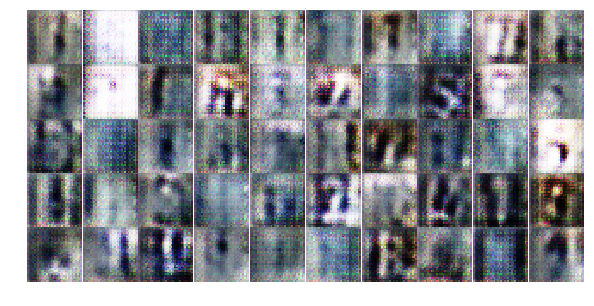

Epoch 1
		Classifier train accuracy:  0.7154
		Classifier test accuracy 0.714582052858
		Step time:  0.038102149963378906
		Epoch time:  43.58894181251526


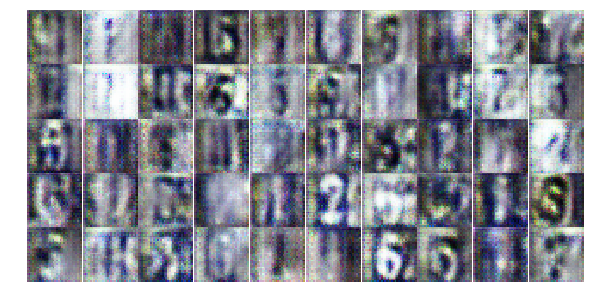

Epoch 2
		Classifier train accuracy:  0.7812
		Classifier test accuracy 0.74815611555
		Step time:  0.03409075736999512
		Epoch time:  43.688926696777344


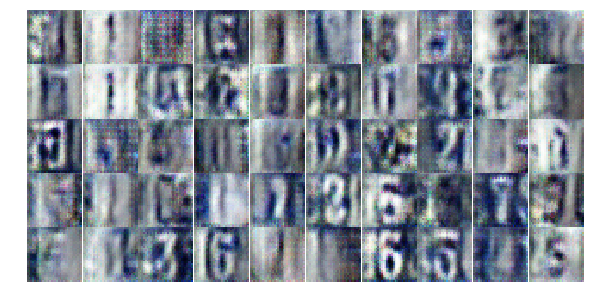

Epoch 3
		Classifier train accuracy:  0.818
		Classifier test accuracy 0.761447449293
		Step time:  0.03509330749511719
		Epoch time:  43.469879150390625


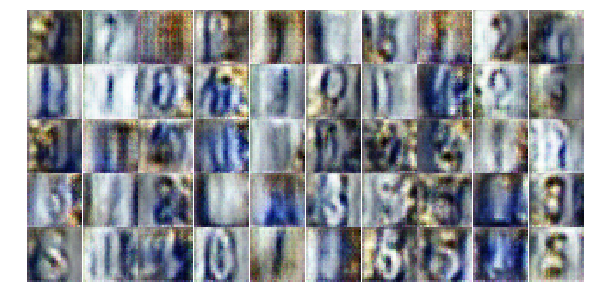

Epoch 4
		Classifier train accuracy:  0.8308
		Classifier test accuracy 0.763214505224
		Step time:  0.035092830657958984
		Epoch time:  43.56939649581909


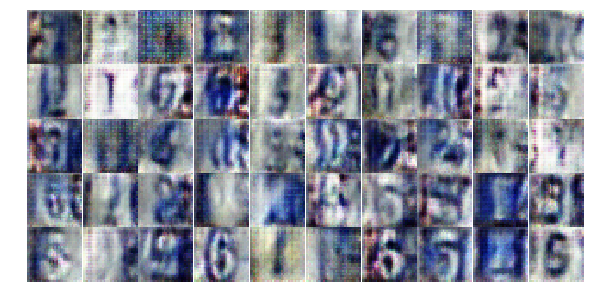

Epoch 5
		Classifier train accuracy:  0.836
		Classifier test accuracy 0.757682851875
		Step time:  0.03509330749511719
		Epoch time:  43.530802965164185


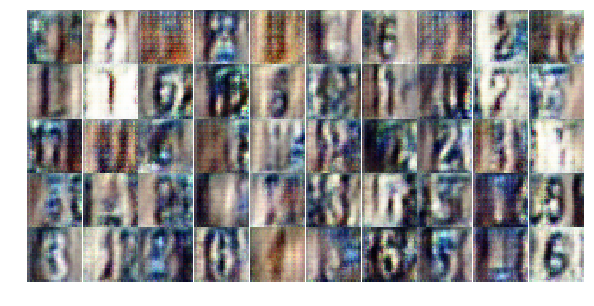

Epoch 6
		Classifier train accuracy:  0.8374
		Classifier test accuracy 0.745313460356
		Step time:  0.03369331359863281
		Epoch time:  43.65976405143738


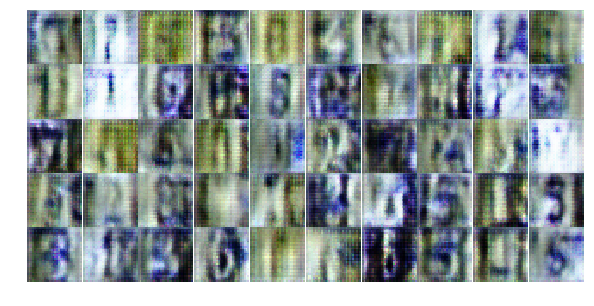

Epoch 7
		Classifier train accuracy:  0.8388
		Classifier test accuracy 0.733020897357
		Step time:  0.03559470176696777
		Epoch time:  44.354373931884766


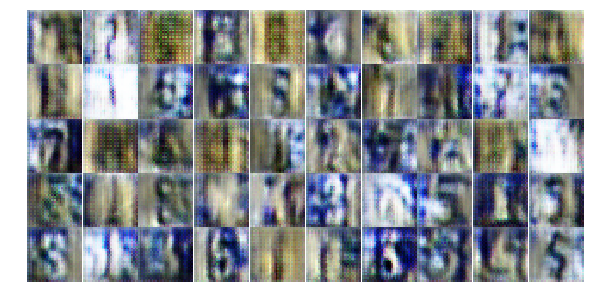

Epoch 8
		Classifier train accuracy:  0.8236
		Classifier test accuracy 0.698371235403
		Step time:  0.04562115669250488
		Epoch time:  45.194722414016724


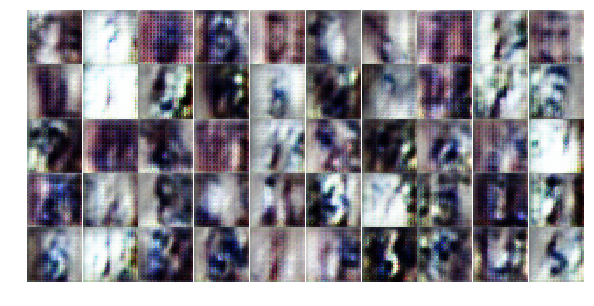

Epoch 9
		Classifier train accuracy:  0.8102
		Classifier test accuracy 0.693070067609
		Step time:  0.03609633445739746
		Epoch time:  45.0493848323822


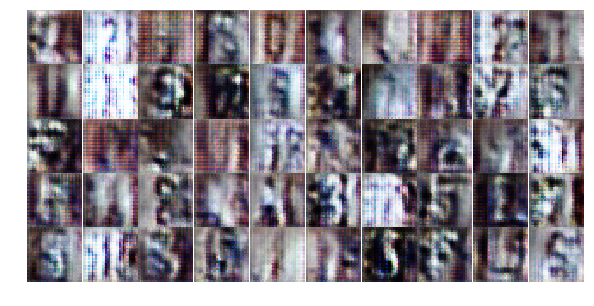

Epoch 10
		Classifier train accuracy:  0.8032
		Classifier test accuracy 0.687999385372
		Step time:  0.037600040435791016
		Epoch time:  45.16167378425598


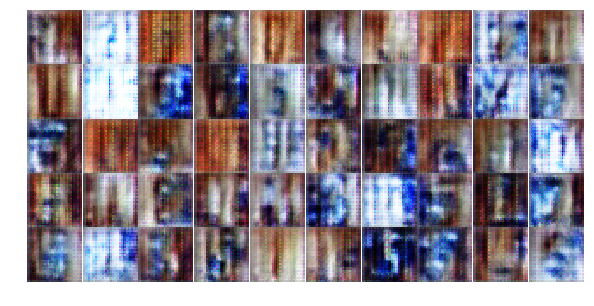

Epoch 11
		Classifier train accuracy:  0.7674
		Classifier test accuracy 0.629379225569
		Step time:  0.03509402275085449
		Epoch time:  45.37025308609009


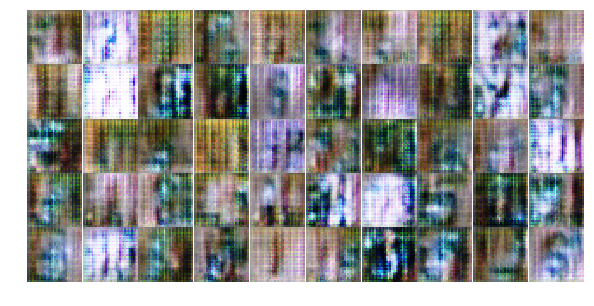

Epoch 12
		Classifier train accuracy:  0.7568
		Classifier test accuracy 0.647280270436
		Step time:  0.03409075736999512
		Epoch time:  45.743863582611084


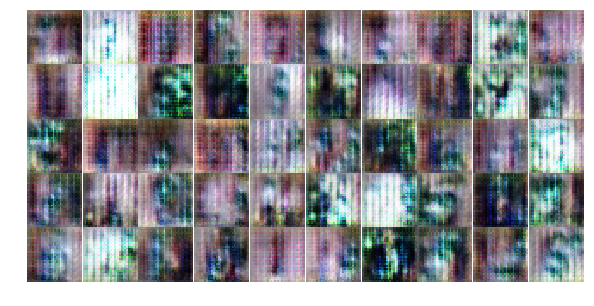

Epoch 13
		Classifier train accuracy:  0.7442
		Classifier test accuracy 0.637599877074
		Step time:  0.0381007194519043
		Epoch time:  45.303982734680176


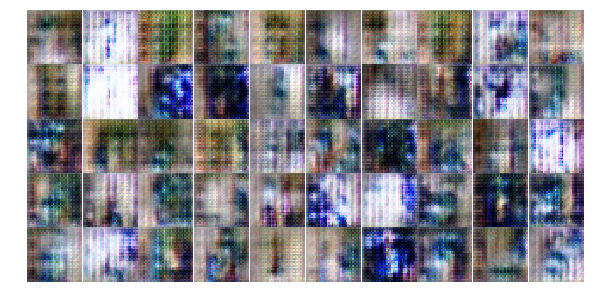

Epoch 14
		Classifier train accuracy:  0.723
		Classifier test accuracy 0.590964966195
		Step time:  0.034090518951416016
		Epoch time:  44.88690257072449


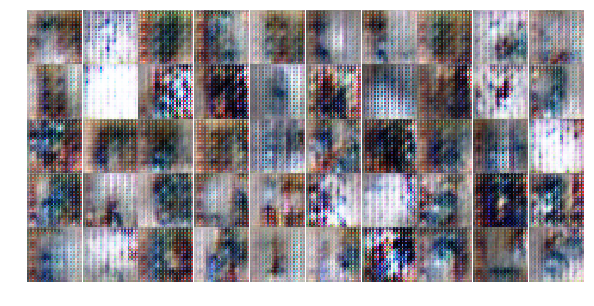

In [250]:
dataset = Dataset(trainset, testset)

batch_size = 64
epochs = 15
train_accuracies, test_accuracies, samples = train(net,
                                                   dataset,
                                                   epochs,
                                                   batch_size,
                                                   figsize=(10,5))

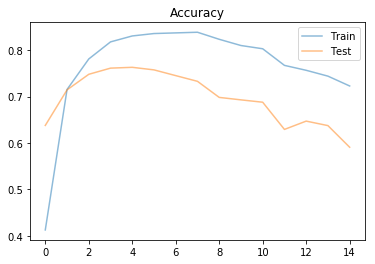

In [251]:
fig, ax = plt.subplots()
#plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

When you run the fully implemented semi-supervised GAN, you should usually find that the test accuracy peaks at 69-71%. It should definitely stay above 68% fairly consistently throughout the last several epochs of training.

This is a little bit better than a [NIPS 2014 paper](https://arxiv.org/pdf/1406.5298.pdf) that got 64% accuracy on 1000-label SVHN with variational methods. However, we still have lost something by not using all the labels. If you re-run with all the labels included, you should obtain over 80% accuracy using this architecture (and other architectures that take longer to run can do much better).

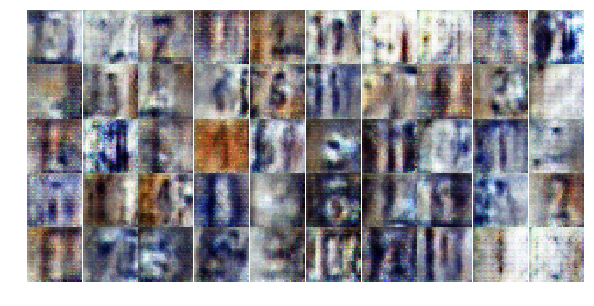

In [51]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))

In [52]:
!mkdir images

하위 디렉터리 또는 파일 images이(가) 이미 있습니다.


In [53]:
for ii in range(len(samples)):
    fig, ax = view_samples(ii, samples, 5, 10, figsize=(10,5))
    fig.savefig('images/samples_{:03d}.png'.format(ii))
    plt.close()

Congratulations! You now know how to train a semi-supervised GAN. This exercise is stripped down to make it run faster and to make it simpler to implement. In the original work by Tim Salimans at OpenAI, a GAN using [more tricks and more runtime](https://arxiv.org/pdf/1606.03498.pdf) reaches over 94% accuracy using only 1,000 labeled examples.